# WNTR simulations without MiniCPS
### These simulations are simply WNTR simulations that do not use MiniCPS, these simulations are used a baseline to validate the other simulations

In [1]:
import matplotlib.pyplot as plt
import wntr
import wntr.network.controls as controls
import sqlite3
import csv
import time
import pandas as pd

In [2]:
# Create the network
inp_file = '../EPANET_topologies/minitown_map.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# Set option for step-by-step simulation
wn.options.time.duration = 900
wn.options.time.hydraulic_timestep = wn.options.time.duration
wn.options.time.pattern_timestep = wn.options.time.duration*4

dd_results_list = []
list_header = []

node_list = list(wn.node_name_list)
junction_list = []
for node in node_list:
    if wn.get_node(node).node_type == 'Junction':
        junction_list.append(str(node))

list_header = ["timestamps", "TANK_LEVEL", "RESERVOIR_LEVEL"]
list_header.extend(junction_list)
another_list = ["FLOW_PUMP1", "FLOW_PUMP2", "STATUS_PUMP1", "STATUS_PUMP2"]
list_header.extend(another_list)

dd_results_list.append(list_header)

tank = wn.get_node("TANK")    # WNTR TANK OBJECT
pump1 = wn.get_link("PUMP1")  # WNTR PUMP OBJECT
pump2 = wn.get_link("PUMP2")  # WNTR PUMP OBJECT
reservoir = wn.get_node("R1")

condition_pump1_open = controls.ValueCondition(tank, 'level', '<', 4.0)
condition_pump1_close = controls.ValueCondition(tank, 'level', '>', 6.3)

condition_pump2_open = controls.ValueCondition(tank, 'level', '<', 1)
condition_pump2_close = controls.ValueCondition(tank, 'level', '>', 4.5)

pump1_open = controls.ControlAction(pump1, 'status', 1)
pump1_close = controls.ControlAction(pump1, 'status', 0)

pump2_open = controls.ControlAction(pump2, 'status', 1)
pump2_close = controls.ControlAction(pump2, 'status', 0)

pump1_control_open = controls.Control(condition_pump1_open, pump1_open, name='pump1control1')
pump1_control_close = controls.Control(condition_pump1_close, pump1_close, name='pump1control2')

pump2_control_open = controls.Control(condition_pump2_open, pump2_open, name='pump2control1')
pump2_control_close = controls.Control(condition_pump2_close, pump2_close, name='pump2control2')

wn.add_control('WnPump1Control1', pump1_control_open)
wn.add_control('WnPump1Control2', pump1_control_close)

wn.add_control('WnPump2Control1', pump2_control_open)
wn.add_control('WnPump2Control2', pump2_control_close)

sim = wntr.sim.WNTRSimulator(wn) 

# START STEP BY STEP SIMULATION
iteration = 0
while iteration <= 672:
    
    results_dd = sim.run_sim(convergence_error=True)

    values_list = []
    values_list.extend([results_dd.timestamp, tank.level, reservoir.head])

    for junction in junction_list:
        values_list.extend([wn.get_node(junction).head - wn.get_node(junction).elevation])

    values_list.extend([pump1.flow, pump2.flow, pump1.status, pump2.status])

    dd_results_list.append(values_list)    
    iteration += 1

C:\Users\Andrea\Anaconda3\lib\site-packages\wntr\epanet\io.py:2085: UserWarning: Not all curves were used in "../EPANET_topologies/minitown_map.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))


In [3]:
# Create the network
inp_file = '../EPANET_topologies/minitown_map.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# Set option for step-by-step simulation
wn.options.time.duration = 900
wn.options.time.hydraulic_timestep = wn.options.time.duration
wn.options.time.pattern_timestep = wn.options.time.duration*4

pdd_results_list = []
list_header = [] 

node_list = list(wn.node_name_list)
junction_list = []
for node in node_list:
    if wn.get_node(node).node_type == 'Junction':
        junction_list.append(str(node))

list_header = ["timestamps", "TANK_LEVEL", "RESERVOIR_LEVEL"]
list_header.extend(junction_list)

another_list = ["FLOW_PUMP1", "FLOW_PUMP2", "STATUS_PUMP1", "STATUS_PUMP2"]
list_header.extend(another_list)

pdd_results_list.append(list_header)

tank = wn.get_node("TANK")    # WNTR TANK OBJECT
pump1 = wn.get_link("PUMP1")  # WNTR PUMP OBJECT
pump2 = wn.get_link("PUMP2")  # WNTR PUMP OBJECT
reservoir = wn.get_node("R1")

condition_pump1_open = controls.ValueCondition(tank, 'level', '<', 4.0)
condition_pump1_close = controls.ValueCondition(tank, 'level', '>', 6.3)

condition_pump2_open = controls.ValueCondition(tank, 'level', '<', 1)
condition_pump2_close = controls.ValueCondition(tank, 'level', '>', 4.5)

pump1_open = controls.ControlAction(pump1, 'status', 1)
pump1_close = controls.ControlAction(pump1, 'status', 0)

pump2_open = controls.ControlAction(pump2, 'status', 1)
pump2_close = controls.ControlAction(pump2, 'status', 0)

pump1_control_open = controls.Control(condition_pump1_open, pump1_open, name='pump1control1')
pump1_control_close = controls.Control(condition_pump1_close, pump1_close, name='pump1control2')

pump2_control_open = controls.Control(condition_pump2_open, pump2_open, name='pump2control1')
pump2_control_close = controls.Control(condition_pump2_close, pump2_close, name='pump2control2')

wn.add_control('WnPump1Control1', pump1_control_open)
wn.add_control('WnPump1Control2', pump1_control_close)

wn.add_control('WnPump2Control1', pump2_control_open)
wn.add_control('WnPump2Control2', pump2_control_close)

# START STEP BY STEP SIMULATION
sim_2 = wntr.sim.WNTRSimulator(wn, mode='PDD')
days_simulated = 7
iteration = 0
iteration_limit = days_simulated*(24*3600) / wn.options.time.duration
while iteration <= iteration_limit:
    results_pdd = sim_2.run_sim(convergence_error=True)
 
    values_list = []
    values_list.extend([results_pdd.timestamp, tank.level, reservoir.head])

    for junction in junction_list:
        values_list.extend([wn.get_node(junction).head - wn.get_node(junction).elevation])

    values_list.extend([pump1.flow, pump2.flow, pump1.status, pump2.status])

    pdd_results_list.append(values_list)
    iteration += 1

In [4]:
with open('no_minicps.csv', 'w', newline='\n') as f:
    writer = csv.writer(f)
    writer.writerows(dd_results_list)

In [5]:
with open('no_minicps_pdd.csv', 'w', newline='\n') as f:
    writer = csv.writer(f)
    writer.writerows(pdd_results_list)

In [6]:
no_minicps_data = pd.read_csv('no_minicps.csv')
no_minicps_data_pdd = pd.read_csv('no_minicps_pdd.csv')

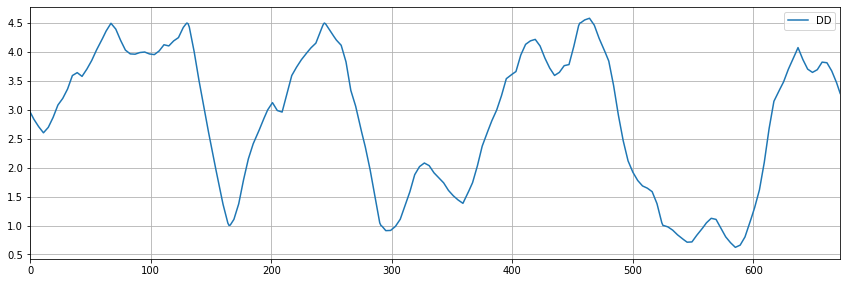

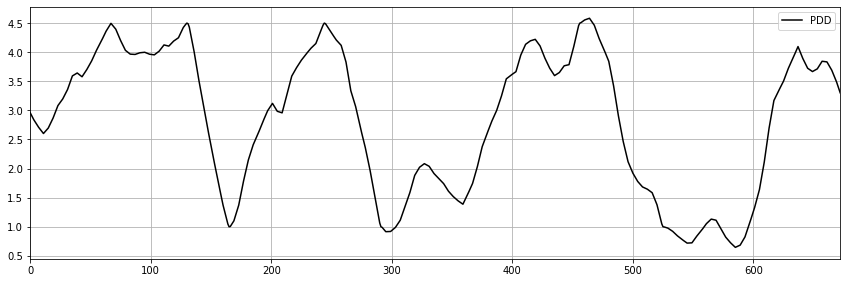

In [7]:
fig, ax = plt.subplots()
no_minicps_data['TANK_LEVEL'].plot(label='DD', ax=ax )
leg = ax.legend()
plt.subplots_adjust(top=1.00, right=2.00)
plt.grid(True)
plt.show()

fig, ax_pdd = plt.subplots()
no_minicps_data_pdd['TANK_LEVEL'].plot(label='PDD', ax=ax_pdd, color="black" )
leg = ax_pdd.legend()
plt.subplots_adjust(top=1.00, right=2.00)
plt.grid(True)
plt.show()

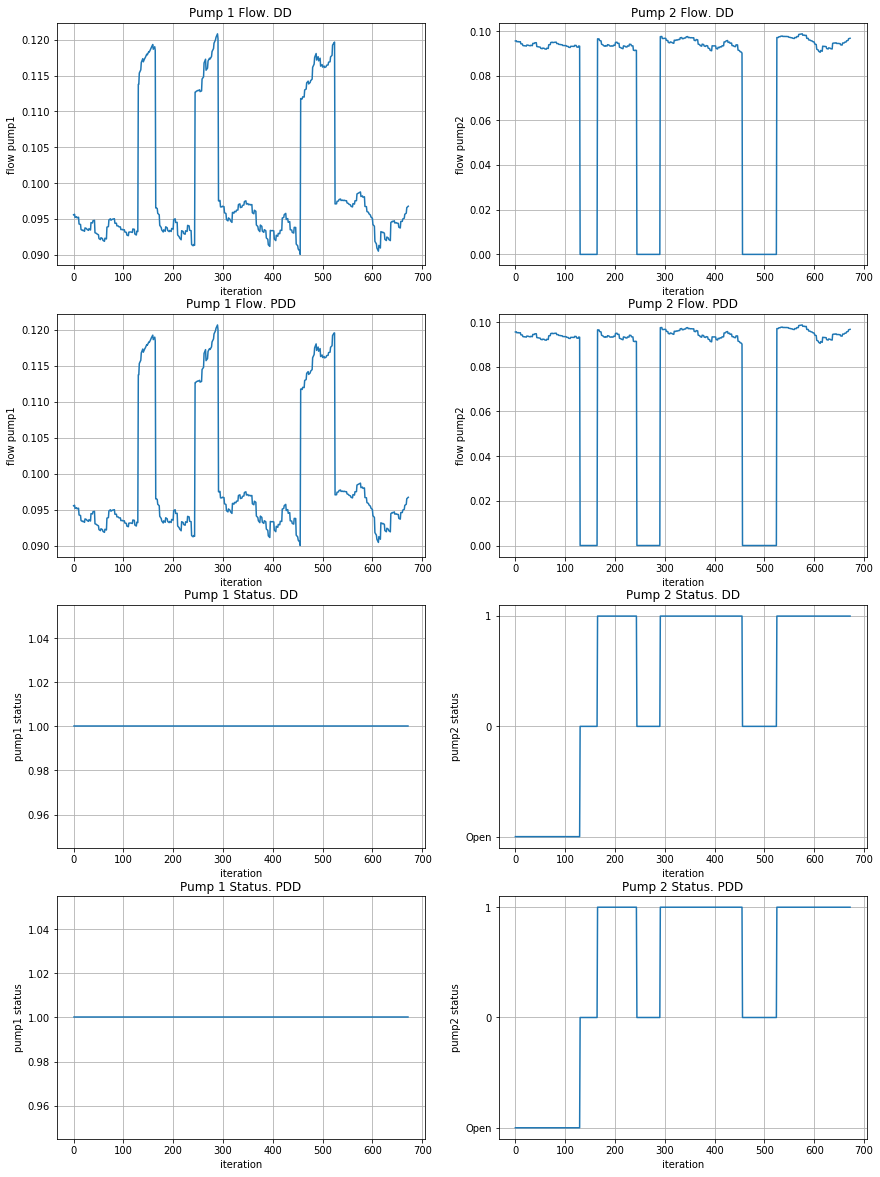

In [8]:
fp1 = no_minicps_data['FLOW_PUMP1']
fp2 = no_minicps_data['FLOW_PUMP2']
sp1 = no_minicps_data['STATUS_PUMP1']
sp2 = no_minicps_data['STATUS_PUMP2']

fp1_pdd = no_minicps_data_pdd['FLOW_PUMP1']
fp2_pdd = no_minicps_data_pdd['FLOW_PUMP2']
sp1_pdd = no_minicps_data_pdd['STATUS_PUMP1']
sp2_pdd = no_minicps_data_pdd['STATUS_PUMP2']

plt.subplot(421)
plt.plot(fp1)
plt.xlabel('iteration')
plt.ylabel('flow pump1')
plt.title('Pump 1 Flow. DD')
plt.grid(True)

plt.subplot(423)
plt.plot(fp1_pdd)
plt.xlabel('iteration')
plt.ylabel('flow pump1')
plt.title('Pump 1 Flow. PDD')
plt.grid(True)


plt.subplot(422)
plt.plot(fp2)
plt.xlabel('iteration')
plt.ylabel('flow pump2')
plt.title('Pump 2 Flow. DD')
plt.grid(True)

plt.subplot(424)
plt.plot(fp2_pdd)
plt.xlabel('iteration')
plt.ylabel('flow pump2')
plt.title('Pump 2 Flow. PDD')
plt.grid(True)


plt.subplot(425)
plt.plot(sp1)
plt.xlabel('iteration')
plt.ylabel('pump1 status')
plt.title('Pump 1 Status. DD')
plt.grid(True)

plt.subplot(427)
plt.plot(sp1_pdd)
plt.xlabel('iteration')
plt.ylabel('pump1 status')
plt.title('Pump 1 Status. PDD')
plt.grid(True)


plt.subplot(426)
plt.plot(sp2)
plt.xlabel('iteration')
plt.ylabel('pump2 status')
plt.title('Pump 2 Status. DD')
plt.grid(True)

plt.subplot(428)
plt.plot(sp2_pdd)
plt.xlabel('iteration')
plt.ylabel('pump2 status')
plt.title('Pump 2 Status. PDD')
plt.grid(True)

plt.subplots_adjust(top=4.00, right=2.00)

plt.show()